# Autoencoder 時間序列異常偵測教學
本教學將以合成資料為例，介紹 autoencoder 在時間序列異常偵測的理論、實作與成效展示。

## 1. 課程簡介
Autoencoder 是一種無監督學習方法，常用於資料降維、特徵學習與異常偵測。
本教學將聚焦於 autoencoder 在時間序列異常偵測的應用，並以合成資料展示其流程與成效。

## 2. Autoencoder 理論與架構
Autoencoder 由 Encoder 與 Decoder 組成，透過壓縮（編碼）與重建（解碼）學習資料的潛在結構。
- **Encoder**：將輸入資料壓縮至低維潛在空間
- **Decoder**：將潛在空間重建回原始資料

重建誤差（如 MSE）可用於判斷資料是否異常，異常資料通常重建誤差較大。

## 3. pyod 套件簡介（簡短）
[pyod](https://pyod.readthedocs.io/en/latest/) 是 Python 的異常偵測工具包，支援多種模型，包括 autoencoder。
本教學僅用 pyod 生成合成資料，autoencoder 實作將以 TensorFlow/Keras 為主。

## 4. 合成資料準備與視覺化
以下將生成含異常的合成時間序列資料，並以視覺化方式展示資料分布與異常狀況。

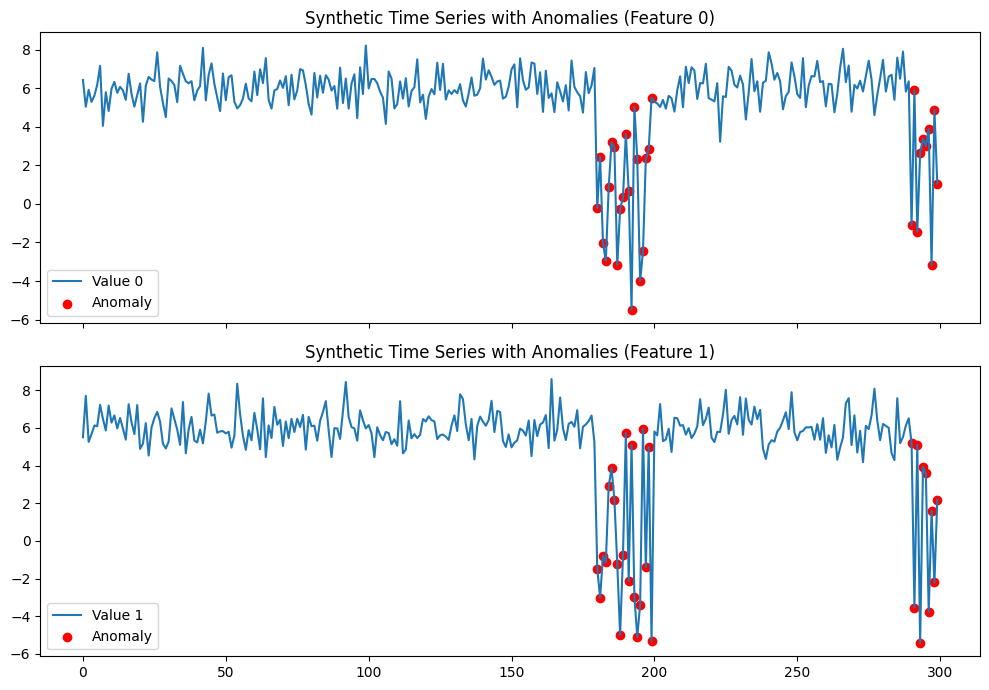

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data

n_train = 200 # 訓練資料數量
n_test = 100 # 測試資料數量
n_features = 2

# 產生合成資料（含異常）
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train,
    n_test=n_test,
    n_features=n_features,
    contamination=0.1,
    random_state=42
)

# 合併訓練與測試資料
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])
df = pd.DataFrame({
    'value_0': X[:, 0],
    'value_1': X[:, 1],
    'anomaly': y
})

# 視覺化資料分布（分別繪製兩個特徵）
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(df[f'value_{i}'], label=f'Value {i}')
    ax.scatter(df.index[df['anomaly']==1], df[f'value_{i}'][df['anomaly']==1], color='r', label='Anomaly')
    ax.set_title(f'Synthetic Time Series with Anomalies (Feature {i})')
    ax.legend()
plt.tight_layout()
plt.show()

## 5. Autoencoder 模型建構與訓練

本範例直接使用 pyod 套件的 AutoEncoder 進行模型建構與訓練，無需手動設計 Keras 結構。

只需指定神經元層數、訓練週期等參數，即可快速完成異常偵測模型。

In [7]:
from pyod.models.auto_encoder import AutoEncoder
from sklearn.preprocessing import MinMaxScaler

# 資料標準化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[['value_0', 'value_1']])

# 建立並訓練 pyod autoencoder 模型
ae_model = AutoEncoder(
  hidden_neuron_list=[8, 4, 4, 8],
  epoch_num=50,
  batch_size=32,
  contamination=0.1,
  verbose=0
)
ae_model.fit(X_scaled)

## 6. 異常偵測流程

利用 pyod AutoEncoder 直接取得異常分數（decision_scores_）與異常標記（labels_），並以分布圖與標記視覺化異常。

無需手動計算重建誤差或設定閾值，流程更簡潔。

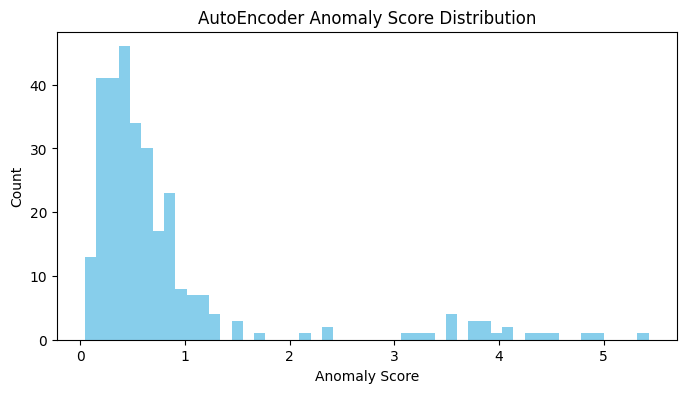

In [8]:
# 取得 pyod autoencoder 異常分數與標記
df['ae_score'] = ae_model.decision_scores_
df['ae_anomaly'] = ae_model.labels_

# 視覺化異常分數分布
plt.figure(figsize=(8, 4))
plt.hist(df['ae_score'], bins=50, color='skyblue')
plt.title('AutoEncoder Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.show()

## 7. 成效分析與討論

將 pyod AutoEncoder 偵測結果（ae_anomaly）與原始異常標記（anomaly）比較，並分別視覺化兩個特徵的異常點。

可直接使用 sklearn 的 classification_report 評估模型偵測成效。

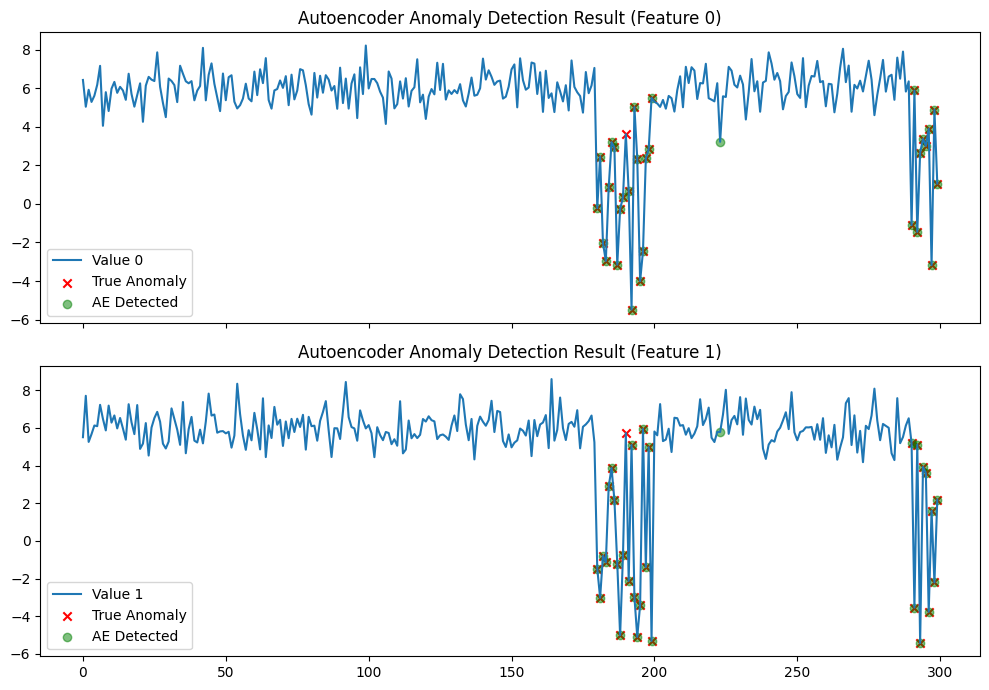

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       270
     Anomaly       0.97      0.97      0.97        30

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



In [9]:
# 分別視覺化兩個特徵的異常點
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(df[f'value_{i}'], label=f'Value {i}')
    ax.scatter(df.index[df['anomaly']==1], df[f'value_{i}'][df['anomaly']==1], color='r', label='True Anomaly', marker='x')
    ax.scatter(df.index[df['ae_anomaly']==1], df[f'value_{i}'][df['ae_anomaly']==1], color='g', label='AE Detected', marker='o', alpha=0.5)
    ax.set_title(f'Autoencoder Anomaly Detection Result (Feature {i})')
    ax.legend()
plt.tight_layout()
plt.show()

# 計算偵測成效
from sklearn.metrics import classification_report
print(classification_report(df['anomaly'], df['ae_anomaly'], target_names=['Normal', 'Anomaly']))

## 8. 結論與參考資料

- pyod AutoEncoder 可快速建構多維度時間序列異常偵測模型，無需手動設計神經網路結構。

- 直接取得異常分數與標記，流程簡潔且易於視覺化與評估。

- 相關資源：

    - [pyod 官方文件](https://pyod.readthedocs.io/en/latest/)

    - [Autoencoder for Time Series Anomaly Detection (Medium)](https://medium.com/@injure21/autoencoder-for-time-series-anomaly-detection-021d4b9c7909)